In [1]:
import pandas as pd
import numpy as np
import os
from os import listdir
from os.path import isfile, join
import time
import random
import re
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
# torch.backends.cudnn.deterministic = True

In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print('Cuda is here')
else:
    device = torch.device('cpu')
print(torch.cuda.is_available())


Cuda is here
True


## Loading the Data

In [3]:
def book_loader(path):
    """Load a book from its file"""
    input_file = os.path.join(path)
    with open(input_file) as f:
        book = f.read()
    return book

In [4]:
path = './books/'
book_files = [f for f in listdir(path) if isfile(join(path, f))]

print('There are {} books: '.format(len(book_files)))
for elem in book_files:
    print(elem)

There are 20 books: 
Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf
Anna_Karenina_by_Leo_Tolstoy.rtf
David_Copperfield_by_Charles_Dickens.rtf
Don_Quixote_by_Miguel_de_Cervantes.rtf
Dracula_by_Bram_Stoker.rtf
Emma_by_Jane_Austen.rtf
Frankenstein_by_Mary_Shelley.rtf
Great_Expectations_by_Charles_Dickens.rtf
Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf
Metamorphosis_by_Franz_Kafka.rtf
Oliver_Twist_by_Charles_Dickens.rtf
Pride_and_Prejudice_by_Jane_Austen.rtf
The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf
The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf
The_Count_of_Monte_Cristo_by_Alexandre_Dumas.rtf
The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf
The_Prince_by_Nicolo_Machiavelli.rtf
The_Romance_of_Lust_by_Anonymous.rtf
The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf
Through_the_Looking_Glass_by_Lewis_Carroll.rtf


In [5]:
books = []
for book in book_files:
    books.append(book_loader(path+book))

In [6]:
lens = [(len(books[i].split()), book_files[i]) for i in range(len(books))]
lens.sort()
for elem in lens:
    print("There are {} words in {}.".format(elem[0], elem[1]))

There are 9463 words in The_Yellow_Wallpaper_by_Charlotte_Perkins_Gilman.rtf.
There are 25395 words in Metamorphosis_by_Franz_Kafka.rtf.
There are 30423 words in Alices_Adventures_in_Wonderland_by_Lewis_Carroll.rtf.
There are 33464 words in Through_the_Looking_Glass_by_Lewis_Carroll.rtf.
There are 53211 words in The_Prince_by_Nicolo_Machiavelli.rtf.
There are 78912 words in Frankenstein_by_Mary_Shelley.rtf.
There are 83657 words in The_Picture_of_Dorian_Gray_by_Oscar_Wilde.rtf.
There are 96185 words in The_Adventures_of_Tom_Sawyer_by_Mark_Twain.rtf.
There are 105428 words in Grimms_Fairy_Tales_by_The_Brothers_Grimm.rtf.
There are 110213 words in The_Adventures_of_Sherlock_Holmes_by_Arthur_Conan_Doyle.rtf.
There are 113452 words in David_Copperfield_by_Charles_Dickens.rtf.
There are 126999 words in Pride_and_Prejudice_by_Jane_Austen.rtf.
There are 163109 words in Emma_by_Jane_Austen.rtf.
There are 165188 words in Oliver_Twist_by_Charles_Dickens.rtf.
There are 166996 words in Dracula_by_

### Let's check for text existence.

In [7]:
books[0][:500]

"{\\rtf1\\ansi\\ansicpg1252\\cocoartf1404\\cocoasubrtf470\n{\\fonttbl\\f0\\fmodern\\fcharset0 Courier;}\n{\\colortbl;\\red255\\green255\\blue255;\\red0\\green0\\blue0;}\n\\margl1440\\margr1440\\vieww10800\\viewh8400\\viewkind0\n\\deftab720\n\\pard\\pardeftab720\\sl280\\partightenfactor0\n\n\\f0\\fs24 \\cf2 \\expnd0\\expndtw0\\kerning0\n\\outl0\\strokewidth0 \\strokec2 Project Gutenberg\\'92s Alice\\'92s Adventures in Wonderland, by Lewis Carroll\\\n\\\nThis eBook is for the use of anyone anywhere at no cost and with\\\nalmost no restrictions what"

### There are a lot of trash in *.rtf.

In [8]:
def clean_text(text):
    '''Remove unwanted characters and extra spaces from the text'''
    text = text[326:-1] # Header removing.
    # text = re.sub('www.gutenberg.(net|org)', '.', text)
    # text = re.sub(' www.gutenberg.org', '.', text)
    text = re.sub('www.gutenberg.(net|org)(\/license)*(\.)*', 'our website.', text)
    text = re.sub(r'\n', ' ', text)
    text = re.sub(r'[{}@_*>()\\#%+=\[\]]', '', text)
    text = re.sub('a0', '', text)
    text = re.sub('\'92t', '\'t', text)
    text = re.sub('\'92s', '\'s', text)
    text = re.sub('\'92m', '\'m', text)
    text = re.sub('\'92ll', '\'ll', text)
    text = re.sub('\'91', '', text)
    text = re.sub('\'92', '', text)
    text = re.sub('\'93', '', text)
    text = re.sub('\'94', '', text)
    text = re.sub('\.', '. ', text)
    text = re.sub('\!', '! ', text)
    text = re.sub('\?', '? ', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('"', ' ', text)
    return text

In [9]:
clean_books = []
for book in books:
    clean_books.append(clean_text(book))
# clean_books.append(clean_text(books[0]))

### Let's check.

In [10]:
clean_books[3][:500]

' The Project Gutenberg EBook of Don Quixote, by Miguel de Cervantes This eBook is for the use of anyone anywhere at no cost and with almost no restrictions whatsoever. You may copy it, give it away or re-use it under the terms of the Project Gutenberg License included with this eBook or online at our website. Title: Don Quixote Author: Miguel de Cervantes Saavedra Release Date: July 27, 2004 EBook 996 Last Updated: March 4,2015 Language: English START OF THIS PROJECT GUTENBERG EBOOK DON QUIXOTE '

### We'll need a dictionary to convert character <---> integers

In [11]:
vocab_to_int = {}
count = 0
for book in clean_books:
    for character in book:
        if character not in vocab_to_int:
            vocab_to_int[character] = count
            count += 1

tokens = ['<PAD>', '<EOS>', '<SOS>']
for token in tokens:
    vocab_to_int[token] = count
    count += 1

int_to_vocab = {}
for character, value in vocab_to_int.items():
    int_to_vocab[value] = character

In [12]:
vocab_size = len(vocab_to_int)
print("The vocabulary contains {} characters.".format(vocab_size))
print(sorted(vocab_to_int))

The vocabulary contains 77 characters.
[' ', '!', '$', '&', "'", ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<EOS>', '<PAD>', '<SOS>', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Now let's split text into sentences

In [13]:
sentences = []
splited = []

for book in clean_books:
    raw_splited = book.split('. ')
    for sent in raw_splited:
        for first_splited in sent.split('! '):
            for second_splited in first_splited.split('? '):
                splited.append(second_splited+'.')   # So, model won't know about '!' and '?'. Bad..

# for book in clean_books:
#     for sentence in book.split('. '):
#     # for sentence in re.split('. |! |\? ', book):
#         sentences.append(sentence + '.')
sentences = splited
print("There are {} sentences.".format(len(sentences)))

There are 161985 sentences.


In [14]:
sentences[10:15]

['In another moment down went Alice after it, never once considering how in the world she was to get out again.',
 'The rabbit-hole went straight on like a tunnel for some way, and then dipped suddenly down, so suddenly that Alice had not a moment to think about stopping herself before she found herself falling down a very deep well.',
 'Either the well was very deep, or she fell very slowly, for she had plenty of time as she went down to look about her and to wonder what was going to happen next.',
 'First, she tried to look down and make out what she was coming to, but it was too dark to see anything; then she looked at the sides of the well, and noticed that they were filled with cupboards and book-shelves; here and there she saw maps and pictures hung upon pegs.',
 'She took down a jar from one of the shelves as she passed; it was labelled ORANGE MARMALADE, but to her great disappointment it was empty: she did not like to drop the jar for fear of killing somebody, so managed to put

In [15]:
int_sentences = []

for sentence in sentences:
    int_sentence = [vocab_to_int[character] for character in sentence]
    int_sentences.append(int_sentence)

In [16]:
# int_sentences[10:15]

In [17]:
lengths = []
for sentence in int_sentences:
    lengths.append(len(sentence))
lengths = pd.DataFrame(lengths, columns=["counts"])

In [18]:
lengths.describe()

,counts
count,161985.000000
mean,99.069222
std,103.371173
min,1.000000
25%,31.000000
50%,70.000000
75%,135.000000
max,8906.000000


In [19]:
max_length = 100
min_length = 10

good_sentences = []

for sentence in int_sentences:
    if max_length >= len(sentence) >= min_length:
        good_sentences.append(sentence)

print("We will use {} sentences. ".format(len(good_sentences)))

We will use 90733 sentences. 


In [20]:
# good_sentences = good_sentences[:10000]
train_data, test_data = train_test_split(good_sentences, test_size = 0.1, random_state = SEED)
train_data, val_data = train_test_split(train_data, test_size = 0.2, random_state = SEED)

print("Number of training sentences:", len(train_data))
print("Number of testing sentences:", len(test_data))
print("Number of validation sentences:", len(val_data))

Number of training sentences: 65327
Number of testing sentences: 9074
Number of validation sentences: 16332


In [21]:
for i in range(105, 110):
    sentence = ''
    for j in train_data[i]:
        sentence+=int_to_vocab[j]
    # sentence = [int_to_vocab[j] for j in training_sorted[i]]
    print(str(sentence))


   Yes, there's something of a sophistry about that,  Veslovsky agreed.
I think you hailed me, Mademoiselle Julie.
no, I could not endure William Coxe--a pert young lawyer.
Weston, and had half a mind to take it up; but she struggled, and let it pass.
Only it's no good your talking to her.


In [22]:
alphabet = [chr(i) for i in range(97, 123)]
# print(alphabet)

def noise_maker(sentence, threshold):
    '''Relocate, remove, or add characters to create spelling mistakes'''

    noisy_sentence = []
    i = 0
    while i < len(sentence):
        random = np.random.uniform()
        if random < threshold:
            noisy_sentence.append(sentence[i])
        else:
            random = np.random.uniform()
            # 25% chance to swap locations
            if random >= 0.75:
                if i == (len(sentence) - 1):
                    # Last character will not be typed
                    continue
                else:
                    noisy_sentence.append(sentence[i+1])
                    noisy_sentence.append(sentence[i])
                    i += 1
            # 25% chance to add an extra lower case letter
            elif random > 0.5:
                random_letter = np.random.choice(alphabet, 1)[0]
                noisy_sentence.append(vocab_to_int[random_letter])
                noisy_sentence.append(sentence[i])
            # 25% chance of typos
            elif random >= 0.25:
                random_letter = np.random.choice(alphabet, 1)[0]
                noisy_sentence.append(vocab_to_int[random_letter])
            else:
                pass
        i += 1
    return noisy_sentence

In [23]:

threshold = 0.9
for i in range(6100, 6105):
    sentence = ''
    noizy_sentence = ''
    for j in train_data[i]:
        sentence+=int_to_vocab[j]
    for j in noise_maker(train_data[i], threshold):
        noizy_sentence+=int_to_vocab[j]

    print(sentence)
    print(noizy_sentence)
    print()

and it's high time I did, and go to the devil with you.
and it'sh igh time I didt, and o to thme devil with oy.u

I will give him the good one, said he; I am sure he deserves it.
I will gve him the goyodj one, yaid hI  a msurle hhe destrves it.

We were longer this bout, and enjoyed it more.
W weer longerj this bouto,a nd denjoyed it morae.

' 'If that ain't mine.
' 'If that ian'ht mine.

No, father, stammered Villefort; at least, I hope not.
No, fathue,r stammeree Villefort qgt leastm, I hope not.



## Building the Model

In [24]:
def pad_sentences(sentences):
    """ Pad sentences with <PAD> """
    max_sentence = max([len(sentence) for sentence in sentences])
    return [sentence + [vocab_to_int['<PAD>']] * (max_sentence - len(sentence)) for sentence in sentences]

In [25]:
class Generator(Dataset):
    def __init__(self, data):
        self.data = data
        self.pad_sentences_noisy = np.array([])
        self.pad_sentences = np.array([])

    def generate_dataset(self):
        noisy_sentences = []
        for sentence in self.data:
            noisy_sent = [vocab_to_int['<SOS>']]
            noisy_sent+=noise_maker(sentence, threshold)
            noisy_sentences.append(noisy_sent)


        eos_sentences = []
        for sentence in self.data:
            eos_sentence = [vocab_to_int['<SOS>']]
            eos_sentence+=sentence
            eos_sentence.append(vocab_to_int['<EOS>'])
            eos_sentences.append(eos_sentence)

        self.pad_sentences = np.array(pad_sentences(eos_sentences))
        self.pad_sentences_noisy = np.array(pad_sentences(noisy_sentences))

        # So source is like '<SOS>Xyz<PAD><PAD><PAD>'
        # And target is like '<SOS>Xyz<EOS><PAD><PAD><PAD><PAD><PAD>'
        # Lengths could be different

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return torch.tensor(self.pad_sentences_noisy[index]), \
               torch.tensor(self.pad_sentences[index])

In [26]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        # src = [src len, batch size]

        embedded = self.dropout(self.embedding(src))
        # embedded = [src len, batch size, emb dim]

        outputs, (hidden, cell) = self.rnn(embedded)
        # outputs = [src len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        return hidden, cell

In [27]:
class Decoder(nn.Module):   # Is for one step => seq len == 1
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers

        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim, n_layers, dropout = dropout)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, input, hidden, cell):
        # input = [batch size]
        # n directions == 1
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]

        input = input.unsqueeze(0)
        # input = [1, batch size]

        embedded = self.dropout(self.embedding(input))
        # embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))
        prediction = self.fc_out(output.squeeze(0))
        # output = [seq len, batch size, hid dim * n directions]
        # hidden = [n layers * n directions, batch size, hid dim]
        # cell = [n layers * n directions, batch size, hid dim]
        # prediction = [batch size, output dim]

        return prediction, hidden, cell

In [28]:
class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        assert encoder.hid_dim == decoder.hid_dim, \
            "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5):
        # src = [src len, batch size]
        # trg = [trg len, batch size]
        # teacher_forcing_ratio is probability to use teacher forcing

        batch_size = trg.shape[1]
        trg_len = trg.shape[0]
        trg_vocab_size = self.decoder.output_dim

        hidden, cell = self.encoder(src)

        # decoder outputs
        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        # first decoder input is <sos>
        input = trg[0,:]

        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output

            # decide if we are going to use teacher forcing or not
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1)
            input = trg[t] if teacher_force else top1

        return outputs

In [29]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5


# learning_rate = 0.0005
# direction = 2
# threshold = 0.95
# embedding_size = 128
# batch_size = 128


enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

In [30]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)

model.apply(init_weights)

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(77, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(77, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (fc_out): Linear(in_features=512, out_features=77, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 7,435,341 trainable parameters


In [32]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()

    loss_hstr = []
    acc_hstr = []

    for i, (src, trg) in enumerate(tqdm(iterator)):
        optimizer.zero_grad()

        src = src.clone().detach().to(device).transpose(0,1)
        trg = trg.clone().detach().to(device).transpose(0,1)

        output = model(src, trg)

        _, idx = torch.max(output, -1)
        correct = torch.sum(trg == idx)
        acc = correct/(idx.shape[0]*idx.shape[1])
        acc_hstr.append(acc.cpu())

        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].reshape(-1)
        loss = criterion(output, trg)
        loss.backward()
        loss_hstr.append(loss.item())

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()



    return loss_hstr, acc_hstr

In [33]:
def evaluate(model, iterator, criterion):

    model.eval()

    loss_hstr = []
    acc_hstr = []

    with torch.no_grad():

        for i, (src, trg) in enumerate(iterator):
            src = src.clone().detach().to(device).transpose(0,1)
            trg = trg.clone().detach().to(device).transpose(0,1)

            output = model(src, trg, 0) #turn off teacher forcing

            _, idx = torch.max(output, -1)
            correct = torch.sum(trg == idx)
            acc = correct/(idx.shape[0]*idx.shape[1])
            acc_hstr.append(acc.cpu())

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].reshape(-1)
            loss = criterion(output, trg)

            loss_hstr.append(loss.item())

    return loss_hstr, acc_hstr

In [34]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [35]:
N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index = vocab_to_int['<PAD>'])

train_ds = Generator(train_data)
train_ds.generate_dataset()
train_loader = torch.utils.data.DataLoader(train_ds, batch_size=50)

val_ds = Generator(val_data)
val_ds.generate_dataset()
val_loader = torch.utils.data.DataLoader(val_ds, batch_size=50)

train_loss_history = []
train_loss_avgs = []
train_acc_history = []
train_acc_avgs =[]

val_loss_history = []
val_loss_avgs = []
val_acc_history = []
val_acc_avgs =[]

for epoch in tqdm(range(N_EPOCHS)):
    start_time = time.time()

    train_loss, train_acc = train(model, train_loader, optimizer, criterion, CLIP)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    train_loss_history+=train_loss
    train_loss_avgs.append(np.mean(train_loss))
    train_acc_history+=train_acc
    train_acc_avgs.append(np.mean(train_acc))

    val_loss_history+=val_loss
    val_loss_avgs.append(np.mean(val_loss))
    val_acc_history+=val_acc
    val_acc_avgs.append(np.mean(val_acc))



    if val_loss_avgs[-1] < best_valid_loss:
        best_valid_loss = val_loss_avgs[-1]
        torch.save(model.state_dict(), 'model_clip_1.pt')

    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss_avgs[-1]:.3f}, Train acc: {train_acc_avgs[-1]:.3f}')
    print(f'\t Val. Loss: {val_loss_avgs[-1]:.3f}, Val acc: {val_acc_avgs[-1]:.3f}')

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 01 | Time: 2m 42s
	Train Loss: 2.629, Train acc: 0.131
	 Val. Loss: 3.086, Val acc: 0.087


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 02 | Time: 2m 49s
	Train Loss: 2.407, Train acc: 0.158
	 Val. Loss: 2.979, Val acc: 0.097


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 03 | Time: 2m 43s
	Train Loss: 2.285, Train acc: 0.175
	 Val. Loss: 2.921, Val acc: 0.108


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 04 | Time: 2m 48s
	Train Loss: 2.191, Train acc: 0.188
	 Val. Loss: 2.866, Val acc: 0.117


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 05 | Time: 2m 43s
	Train Loss: 2.130, Train acc: 0.196
	 Val. Loss: 2.832, Val acc: 0.122


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 06 | Time: 2m 49s
	Train Loss: 2.073, Train acc: 0.204
	 Val. Loss: 2.808, Val acc: 0.124


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 07 | Time: 2m 46s
	Train Loss: 2.019, Train acc: 0.210
	 Val. Loss: 2.724, Val acc: 0.134


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 08 | Time: 2m 39s
	Train Loss: 1.970, Train acc: 0.217
	 Val. Loss: 2.679, Val acc: 0.138


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 09 | Time: 2m 48s
	Train Loss: 1.929, Train acc: 0.223
	 Val. Loss: 2.720, Val acc: 0.134


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 10 | Time: 2m 44s
	Train Loss: 1.882, Train acc: 0.229
	 Val. Loss: 2.745, Val acc: 0.134


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 11 | Time: 2m 50s
	Train Loss: 1.839, Train acc: 0.235
	 Val. Loss: 2.834, Val acc: 0.126


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 12 | Time: 2m 48s
	Train Loss: 1.801, Train acc: 0.240
	 Val. Loss: 2.676, Val acc: 0.138


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 13 | Time: 2m 45s
	Train Loss: 1.766, Train acc: 0.244
	 Val. Loss: 2.717, Val acc: 0.140


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 14 | Time: 2m 42s
	Train Loss: 1.744, Train acc: 0.247
	 Val. Loss: 2.659, Val acc: 0.142


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 15 | Time: 2m 42s
	Train Loss: 1.727, Train acc: 0.249
	 Val. Loss: 2.694, Val acc: 0.142


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 16 | Time: 2m 42s
	Train Loss: 1.694, Train acc: 0.253
	 Val. Loss: 2.681, Val acc: 0.145


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 17 | Time: 2m 42s
	Train Loss: 1.660, Train acc: 0.258
	 Val. Loss: 2.654, Val acc: 0.148


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 18 | Time: 2m 41s
	Train Loss: 1.630, Train acc: 0.262
	 Val. Loss: 2.602, Val acc: 0.151


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 19 | Time: 2m 42s
	Train Loss: 1.613, Train acc: 0.264
	 Val. Loss: 2.676, Val acc: 0.148


  0%|          | 0/1307 [00:00<?, ?it/s]

Epoch: 20 | Time: 2m 43s
	Train Loss: 1.593, Train acc: 0.267
	 Val. Loss: 2.645, Val acc: 0.152


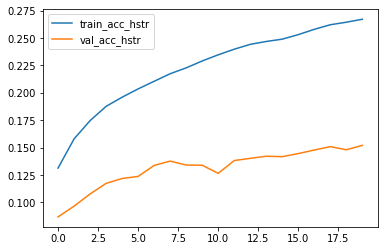

In [36]:
plt.plot(train_acc_avgs)
plt.plot(val_acc_avgs)
plt.gca().legend(('train_acc_hstr', 'val_acc_hstr'))
plt.show()


In [37]:
best_valid_loss = float('inf')

test_ds = Generator(test_data)
test_ds.generate_dataset()
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=50)

loss_hstr, acc_hstr = evaluate(model, test_loader, criterion)
print(f'\tTest Loss: {np.mean(loss_hstr):.3f}, Test Acc: {np.mean(acc_hstr):.3f}')


	Test Loss: 2.646, Test Acc: 0.151


# Need to train better..

In [40]:
def predict(input):
    double_len = len(input)*2
    tgt = [vocab_to_int['<SOS>']]
    tgt += [vocab_to_int['<PAD>']] * double_len
    tgt = torch.tensor(tgt).to(device)
    tgt = torch.reshape(tgt, (-1,1))


    inted_sent = [[vocab_to_int['<SOS>']]]
    for letter in input:
        inted_sent.append([vocab_to_int[letter]])

    inted_sent = torch.tensor(np.array(inted_sent)).to(device)

    sent = None
    with torch.no_grad():
            output = model(inted_sent, tgt, 0)
            val, idx = torch.max(output, 2)

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]


            output = output[1:].view(-1, output_dim)
            sent = idx.reshape((idx.shape[0]))

    sentence = ''
    for j in sent:
        if int_to_vocab[j.item()] == '<EOS>':
            return sentence
        sentence+=int_to_vocab[j.item()]

    return sentence

In [41]:
sent = 'Let me show uyo something'
print(predict(sent))

 ro you was  enting in Mr.
